<a href="https://colab.research.google.com/github/emirgsag/AIRLearn/blob/main/NER/ner_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

--2024-03-26 10:25:45--  https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757208 (4.5M) [application/octet-stream]
Saving to: ‘ner_train.pkl’

ner_train.pkl       100%[===================>]   4.54M  3.62MB/s    in 1.3s    

2024-03-26 10:25:47 (3.62 MB/s) - ‘ner_train.pkl’ saved [4757208/4757208]

--2024-03-26 10:25:47--  https://lazyprogrammer.me/course_files/nlp/ner_test.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201978 (1.1M) [application/octet-stream]
Saving to: ‘ner_test.pkl’

ner_test.pkl        100%[===========

In [4]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [12]:
print(corpus_train[0], corpus_train[1])

[('EU', 'B-ORG'), ('rejects', 'O'), ('German', 'B-MISC'), ('call', 'O'), ('to', 'O'), ('boycott', 'O'), ('British', 'B-MISC'), ('lamb', 'O'), ('.', 'O')] [('The', 'O'), ('European', 'B-ORG'), ('Commission', 'I-ORG'), ('said', 'O'), ('on', 'O'), ('Thursday', 'O'), ('it', 'O'), ('disagreed', 'O'), ('with', 'O'), ('German', 'B-MISC'), ('advice', 'O'), ('to', 'O'), ('consumers', 'O'), ('to', 'O'), ('shun', 'O'), ('British', 'B-MISC'), ('lamb', 'O'), ('until', 'O'), ('scientists', 'O'), ('determine', 'O'), ('whether', 'O'), ('mad', 'O'), ('cow', 'O'), ('disease', 'O'), ('can', 'O'), ('be', 'O'), ('transmitted', 'O'), ('to', 'O'), ('sheep', 'O'), ('.', 'O')]


In [13]:
print(corpus_test[3])

[('After', 'O'), ('bowling', 'O'), ('Somerset', 'B-ORG'), ('out', 'O'), ('for', 'O'), ('83', 'O'), ('on', 'O'), ('the', 'O'), ('opening', 'O'), ('morning', 'O'), ('at', 'O'), ('Grace', 'B-LOC'), ('Road', 'I-LOC'), (',', 'O'), ('Leicestershire', 'B-ORG'), ('extended', 'O'), ('their', 'O'), ('first', 'O'), ('innings', 'O'), ('by', 'O'), ('94', 'O'), ('runs', 'O'), ('before', 'O'), ('being', 'O'), ('bowled', 'O'), ('out', 'O'), ('for', 'O'), ('296', 'O'), ('with', 'O'), ('England', 'B-LOC'), ('discard', 'O'), ('Andy', 'B-PER'), ('Caddick', 'I-PER'), ('taking', 'O'), ('three', 'O'), ('for', 'O'), ('83', 'O'), ('.', 'O')]


In [14]:
train_inputs = []
train_targets = []
for sentence_tag_pairs in corpus_train:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)

In [22]:
train_inputs[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [18]:
train_targets[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [19]:
test_inputs = []
test_targets = []
for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [24]:
test_inputs[0]

['CRICKET',
 '-',
 'LEICESTERSHIRE',
 'TAKE',
 'OVER',
 'AT',
 'TOP',
 'AFTER',
 'INNINGS',
 'VICTORY',
 '.']

In [21]:
test_targets[0]

['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [26]:
MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

In [27]:
# it's ok to "fit" on the whole corpus - it just means some embeddings
# won't be trained
# this is because for the test set, any unknown tokens will be removed
# which will change the length of the input (***CHECK)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [28]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 23299 unique tokens.


In [29]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [30]:
all_train_targets = set(flatten(train_targets))
all_test_targets = set(flatten(test_targets))
print(all_train_targets == all_test_targets)

True


In [31]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [32]:
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [33]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of data train tensor: (12733, 113)
Shape of data test tensor: (2970, 113)
Shape of train targets tensor: (12733, 113)
Shape of test targets tensor: (2970, 113)


In [34]:
print(train_targets_int_unpadded[0])
print(train_targets_int[0])

[4, 1, 7, 1, 1, 1, 7, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 7 1 1 1 7
 1 1]


In [37]:
tag_tokenizer.word_index

{'o': 1,
 'b-per': 2,
 'b-loc': 3,
 'b-org': 4,
 'i-per': 5,
 'i-org': 6,
 'b-misc': 7,
 'i-loc': 8,
 'i-misc': 9}

In [38]:
K = len(tag_tokenizer.word_index) + 1

In [39]:
D = 32

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
# x = SimpleRNN(32, return_sequences=True)(x)
x = Dense(K)(x)

model = Model(i, x)

In [40]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# 60s per epoch on CPU

print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5
398/398 [==============================] - 70s 149ms/step - loss: 0.7249 - accuracy: 0.8371 - val_loss: 0.4871 - val_accuracy: 0.8624
Epoch 2/5
398/398 [==============================] - 55s 139ms/step - loss: 0.3061 - accuracy: 0.9009 - val_loss: 0.3221 - val_accuracy: 0.9099
Epoch 3/5
398/398 [==============================] - 55s 139ms/step - loss: 0.1771 - accuracy: 0.9464 - val_loss: 0.2442 - val_accuracy: 0.9397
Epoch 4/5
398/398 [==============================] - 56s 141ms/step - loss: 0.0952 - accuracy: 0.9760 - val_loss: 0.2050 - val_accuracy: 0.9490
Epoch 5/5
398/398 [==============================] - 55s 138ms/step - loss: 0.0559 - accuracy: 0.9872 - val_loss: 0.1919 - val_accuracy: 0.9520


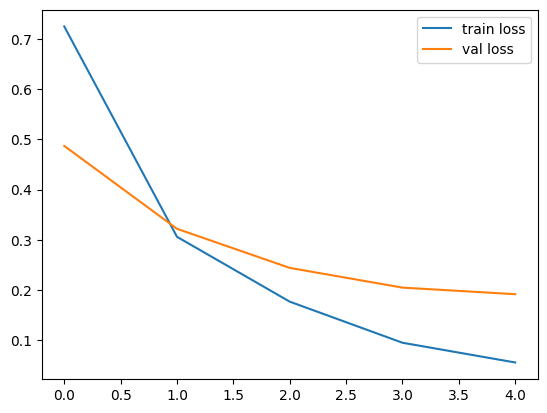

In [41]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

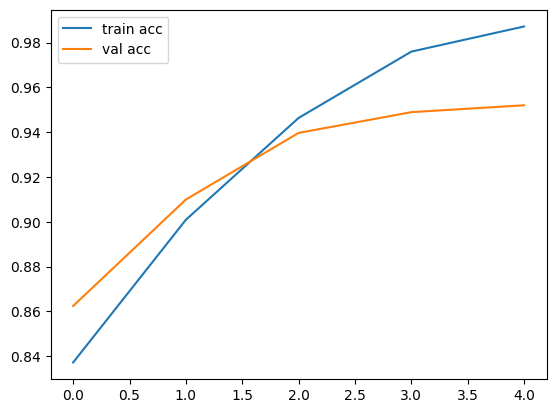

In [42]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [43]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [44]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 15s 29ms/step


In [45]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 5s 55ms/step


In [46]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9916245824717671
Test acc: 0.9520239290001378
Train f1: 0.933984948476433
Test f1: 0.7906237245807242
